# Лабораторная 5. Деревья решений

для данного датасета нужно ввести метрику: студент успешный/неуспешный на основании грейда

In [21]:
import pandas as pd

threshold = 3

data = pd.read_csv("./DATA.csv")
data['SUCCESS'] = data['GRADE'] >= threshold
print(data.head())
print(data.describe())


  STUDENT ID  1  2  3  4  5  6  7  8  9  ...  24  25  26  27  28  29  30  \
0   STUDENT1  2  2  3  3  1  2  2  1  1  ...   1   3   2   1   2   1   1   
1   STUDENT2  2  2  3  3  1  2  2  1  1  ...   1   3   2   3   2   2   3   
2   STUDENT3  2  2  2  3  2  2  2  2  4  ...   1   2   2   1   1   2   2   
3   STUDENT4  1  1  1  3  1  2  1  2  1  ...   2   3   2   2   1   3   2   
4   STUDENT5  2  2  1  3  2  2  1  3  1  ...   1   2   2   2   1   2   2   

   COURSE ID  GRADE  SUCCESS  
0          1      1    False  
1          1      1    False  
2          1      1    False  
3          1      1    False  
4          1      1    False  

[5 rows x 34 columns]
                1           2           3           4           5           6  \
count  145.000000  145.000000  145.000000  145.000000  145.000000  145.000000   
mean     1.620690    1.600000    1.944828    3.572414    1.662069    1.600000   
std      0.613154    0.491596    0.537216    0.805750    0.474644    0.491596   
min      1

Отобрать случайным образом sqrt(n) признаков

In [22]:
import numpy as np

# Select sqrt(n) features randomly
n_features = int(np.sqrt(len(data.columns) - 1))  # Exclude the target column
features = np.random.choice(data.columns[:-1], n_features, replace=False)

features

array(['7', '1', '8', '17', '30'], dtype=object)

Реализовать без использования сторонних библиотек построение дерева решений  (дерево не бинарное, numpy и pandas использовать можно, использовать список списков  для реализации  дерева - нельзя) для решения задачи бинарной классификации 

In [23]:
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, a=None, b=None, c=None, *, leaf_value=None):
        self.feature = feature
        self.threshold = threshold
        self.a = a
        self.b = b
        self.c = c
        self.leaf_value = leaf_value  # None if not a leaf, set to the class if a leaf

def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    entropy = -np.sum([(counts[i] / np.sum(counts)) * np.log2(counts[i] / np.sum(counts)) for i in range(len(elements))])
    return entropy

def info_gain(data, split_feature, target_name="SUCCESS"):
    total_entropy = entropy(data[target_name])
    vals, counts = np.unique(data[split_feature], return_counts=True)
    Weighted_Entropy = np.sum([(counts[i] / np.sum(counts)) * entropy(data.where(data[split_feature] == vals[i]).dropna()[target_name]) for i in range(len(vals))])
    Information_Gain = total_entropy - Weighted_Entropy
    return Information_Gain


def decision_tree(data, features, target_name="SUCCESS", depth=0, max_depth=5):
    if len(np.unique(data[target_name])) <= 1:
        return DecisionTreeNode(leaf_value=np.unique(data[target_name])[0])
    elif len(data) == 0 or depth == max_depth:
        common_target = data[target_name].mode()[0] if not data.empty else 1  # Default to class 1 if data is empty
        return DecisionTreeNode(leaf_value=common_target)
    else:
        # Select the best feature to split on
        info_gains = [info_gain(data, feature) for feature in features]
        best_feature_index = np.argmax(info_gains)
        best_feature = features[best_feature_index]
        tree = DecisionTreeNode(feature=best_feature)
        
        # Split the data and recurse for each subset
        for value in np.unique(data[best_feature]):
            subset = data[data[best_feature] == value]
            new_features = [f for f in features if f != best_feature]
            child_node = decision_tree(subset, new_features, target_name, depth + 1, max_depth)
            if value == 2:
                tree.a = child_node
            elif value == 1:
                tree.b = child_node
            else:
                tree.c = child_node

        # Ensure all branches are covered
        tree.a = tree.a or DecisionTreeNode(leaf_value=2) 
        tree.b = tree.b or DecisionTreeNode(leaf_value=1)
        tree.c = tree.c or DecisionTreeNode(leaf_value=0)
        return tree

# Prediction function
def predict(tree, row):
    while tree.leaf_value is None:
        value = row[tree.feature]
        if value == 2 and tree.a is not None:
            tree = tree.a
        if value == 1 and tree.b is not None:
            tree = tree.b
        elif tree.c is not None:
            tree = tree.c
        else:
            break  # In case of an error in tree structure
    return tree.leaf_value if tree.leaf_value is not None else 1  # Default prediction if tree structure fails

def predict_all(tree, data):
    results = data.apply(lambda row: predict(tree, row), axis=1)
    return results

tree = decision_tree(data, features.tolist())


Провести оценку реализованного алгоритма с использованием Accuracy, precision и recall

In [24]:
def accuracy(actual, predicted):
    correct = np.sum(actual == predicted)
    total = len(actual)
    return correct / total

def precision(actual, predicted):
    true_positive = np.sum((predicted == 1) & (actual == 1))
    predicted_positive = np.sum(predicted == 1)
    return true_positive / predicted_positive if predicted_positive != 0 else 0

def recall(actual, predicted):
    true_positive = np.sum((predicted == 1) & (actual == 1))
    actual_positive = np.sum(actual == 1)
    return true_positive / actual_positive if actual_positive != 0 else 0

# Split data into train and test for evaluation
train_data = data.sample(frac=0.8, random_state=25)
test_data = data.drop(train_data.index)

# Making predictions
predicted = predict_all(tree, test_data)

# Calculating metrics
test_actual = test_data['SUCCESS']
acc = accuracy(test_actual, predicted)
prec = precision(test_actual, predicted)
rec = recall(test_actual, predicted)

print(f"Accuracy: {acc}, Precision: {prec}, Recall: {rec}")


Accuracy: 0.4482758620689655, Precision: 0.5, Recall: 0.5


Построить кривые AUC-ROC и AUC-PR (в пунктах 4 и 5 использовать библиотеки нельзя)

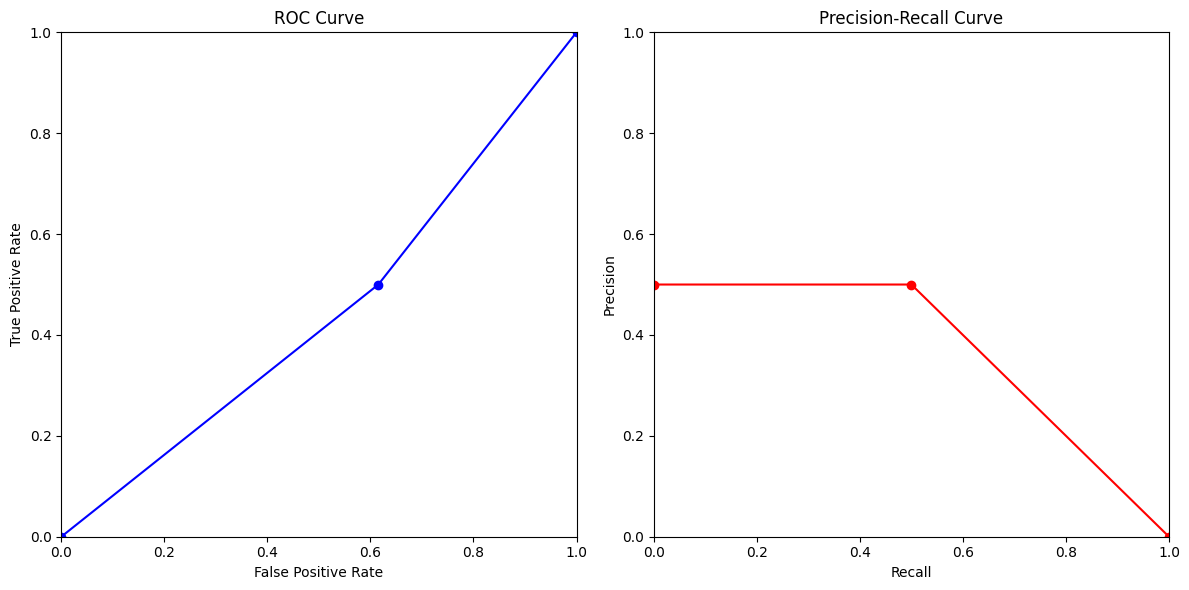

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_tpr_fpr_precision(actual, predicted):
    tp = np.sum((predicted == 1) & (actual == 1))
    fp = np.sum((predicted == 1) & (actual == 0))
    tn = np.sum((predicted == 0) & (actual == 0))
    fn = np.sum((predicted == 0) & (actual == 1))
    
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    return tpr, fpr, precision

# Assuming 'test_actual' contains the true labels and 'predicted' contains the model predictions
tpr, fpr, precision = calculate_tpr_fpr_precision(test_actual, predicted)

# Data for plotting
roc_points = [(0, 0), (fpr, tpr), (1, 1)]
pr_points = [(0, precision), (tpr, precision), (1, 0)]

roc_x, roc_y = zip(*roc_points)
pr_x, pr_y = zip(*pr_points)

# Create ROC curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(roc_x, roc_y, marker='o', linestyle='-', color='b')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0, 1])
plt.ylim([0, 1])

# Create PR curve
plt.subplot(1, 2, 2)
plt.plot(pr_x, pr_y, marker='o', linestyle='-', color='r')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.tight_layout()
plt.show()

